# `photoeccentric` eccentricity fit

In this tutorial, I will use a Kepler light curve to demonstrate how to use `photoeccentric` to recover the planet's eccentricity using the photoeccentric effect [(Dawson & Johnson 2012)](https://arxiv.org/pdf/1203.5537.pdf).

The code I'm using to implement the photoeccentric effect is compiled into a package called `photoeccentric`, and can be viewed/downloaded here: https://github.com/ssagear/photoeccentric

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import os
import pickle
import scipy
import random

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares

# Using juliet & corner to find and plot (e, w) distribution
import juliet
import corner

# Using dynesty to do the same with nested sampling
import dynesty

# And importing `photoeccentric`
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

# pandas display option
pd.set_option('display.float_format', lambda x: '%.5f' % x)

spectplanets = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/datafiles/spectplanets.csv')
muirhead_comb = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/datafiles/muirhead_comb.csv')
muirheadKOIs = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/datafiles/MuirheadKOIs.csv')
lcpath = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/HiPerGator/HPG_Replica/sample_lcs'

plt.rcParams['figure.figsize'] = [20, 10]

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload







I'll define the conversions between solar mass -> kg and solar radius -> meters for convenience.

In [13]:
# smass_kg = 1.9885e30  # Solar mass (kg)
# srad_m = 696.34e6 # Solar radius (m)

## The Sample

I'm using the sample of "cool KOIs" from [Muirhead et al. 2013](https://iopscience.iop.org/article/10.1088/0067-0049/213/1/5), and their properites from spectroscopy published here.

I'm reading in several .csv files containing data for this sample. The data includes spectroscopy data from Muirhead et al. (2013), stellar and planet parameters from the Kepler archive, and distances/luminosities from Gaia. 

In [14]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_incmissing.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = pd.read_csv('datafiles/database/spectplanets.csv')

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = pd.read_csv("datafiles/database/muirhead_gaia.csv")

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.read_csv('datafiles/database/muirhead_comb.csv')

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = pd.read_csv('datafiles/database/muirhead_comb_lums.csv')

In [15]:
# star = ph.KeplerStar(int(np.floor(float(nkoi))))
# star.get_stellar_params(isodf)
# koi = ph.KOI(nkoi, int(np.floor(float(nkoi))), isodf)
# koi.get_KIC(muirhead_comb)
# koi.planet_params_from_archive(spectplanets)
# koi.calc_a(koi.mstar, koi.rstar)

# nbuffer, nlinfit = 7, 6

# KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))
# KOIs = np.sort(np.unique(np.array(muirhead_comb['KOI'])))

# files = ph.get_lc_files(koi.KIC, KICs, lcpath)

# koi.get_stitched_lcs(files)
# koi.get_midpoints()
# koi.remove_oot_data(nbuffer, nlinfit)

# time, flux, fluxerr = koi.time_intransit, koi.flux_intransit, koi.fluxerr_intransit

# Defining a "test planet"


### I'm going to pick a planet from our sample to test how well `photoeccentric` works. Here, I'm picking KOI 254.01

First, I'll use the spectroscopy data from Muirhead et al. 2013 and Gaia luminosities to constrain the mass and radius of the host star beyond the constraint published in the Exoplanet Archive. I'll do this by matching these data with stellar isochrones [MESA](https://iopscience.iop.org/article/10.3847/0004-637X/823/2/102) and using the masses/radii from the matching isochrones to constrian the stellar density.

In [16]:
nkoi = 254.01

I'll read in a file with the  MESA stellar isochrones for low-mass stars. I'll use `ph.fit_isochrone_lum()` to find the subset of stellar isochrones that are consistent with a certain stellar parameters form Kepler-691 (Teff, Mstar, Rstar, and Gaia luminosity). 

In [17]:
# # Read in MESA isochrones
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')


Using `ph.fit_isochrone_lum()` to match isochrones to stellar data:

In [18]:
koi254 = muirhead_comb.loc[muirhead_comb['KOI'] == '251']

In [19]:
iso_lums = ph.fit_isochrone_lum(koi254, isochrones)

  3%|▎         | 25785/738479 [00:00<00:05, 129685.63it/s]

No Gaia luminosity estimates exist for this star. Defaulting to use spectroscopy data only.


100%|██████████| 738479/738479 [00:15<00:00, 48115.33it/s] 


In [20]:
# Write to csv, then read back in (prevents notebook from lagging)
iso_lums.to_csv("tutorial02/iso_lums_" + str(nkoi) + ".csv")

In [21]:
isodf = pd.read_csv("tutorial02/iso_lums_" + str(nkoi) + ".csv")

Define a KeplerStar object, and use  ph.get_stellar_params and the fit isochrones to get the stellar parameters.

In [22]:
SKOI = int(np.floor(float(nkoi)))
print('System KOI', SKOI)

star = ph.KeplerStar(SKOI)
star.get_stellar_params(isodf)

System KOI 254


In [23]:
print('Stellar Mass (Msol): ', star.mstar)
print('Stellar Radius (Rsol): ', star.rstar)
print('Average Stellar Density (kg m^-3): ', star.rho_star)

Stellar Mass (Msol):  0.5243618663369208
Stellar Radius (Rsol):  0.5056960239474314
Average Stellar Density (kg m^-3):  5789.943802913972


Define a KOI object.

In [24]:
koi = ph.KOI(nkoi, SKOI, isodf)
koi.get_KIC(muirhead_comb)

print('KIC', koi.KIC)

KIC 5794240


# Fitting the light curve

In [25]:
koi.planet_params_from_archive(spectplanets)
koi.calc_a(koi.mstar, koi.rstar)

print('Stellar mass (Msun): ', koi.mstar, 'Stellar radius (Rsun): ', koi.rstar)
print('Period (Days): ', koi.period, 'Rp/Rs: ', koi.rprs)
print('a/Rs: ', koi.a_rs)

koi.i = 90.
print('i (deg): ', koi.i)

Stellar mass (Msun):  0.5243618663369208 Stellar radius (Rsun):  0.5056960239474314
Period (Days):  2.455240626 Rp/Rs:  0.170837
a/Rs:  12.201930533103539
i (deg):  90.0


In [26]:
# Define the working directory
direct = 'tutorial02/' + str(nkoi) + '/'

First, reading in the light curves that I have saved for this planet.

In [27]:
KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))
KOIs = np.sort(np.unique(np.array(muirhead_comb['KOI'])))

files = ph.get_lc_files(koi.KIC, KICs, lcpath)

In [28]:
# Stitching the light curves together, preserving the time stamps
koi.get_stitched_lcs(files)

# Getting the midpoint times
koi.get_midpoints()

Text(0, 0.5, 'Flux')

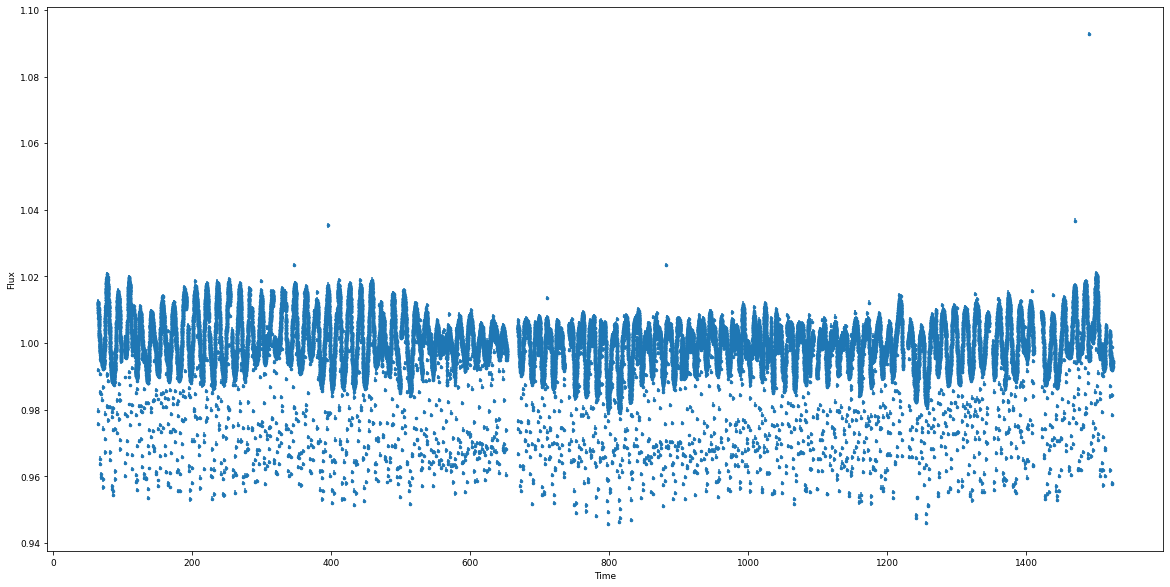

In [29]:
plt.errorbar(koi.time-2454900, koi.flux, yerr=koi.flux_err, fmt='.')
plt.xlabel('Time')
plt.ylabel('Flux')

##### Removing Out of Transit Data

In [30]:
koi.remove_oot_data(7, 6)

Text(0.5, 1.0, 'Transit LC Model with Noise')

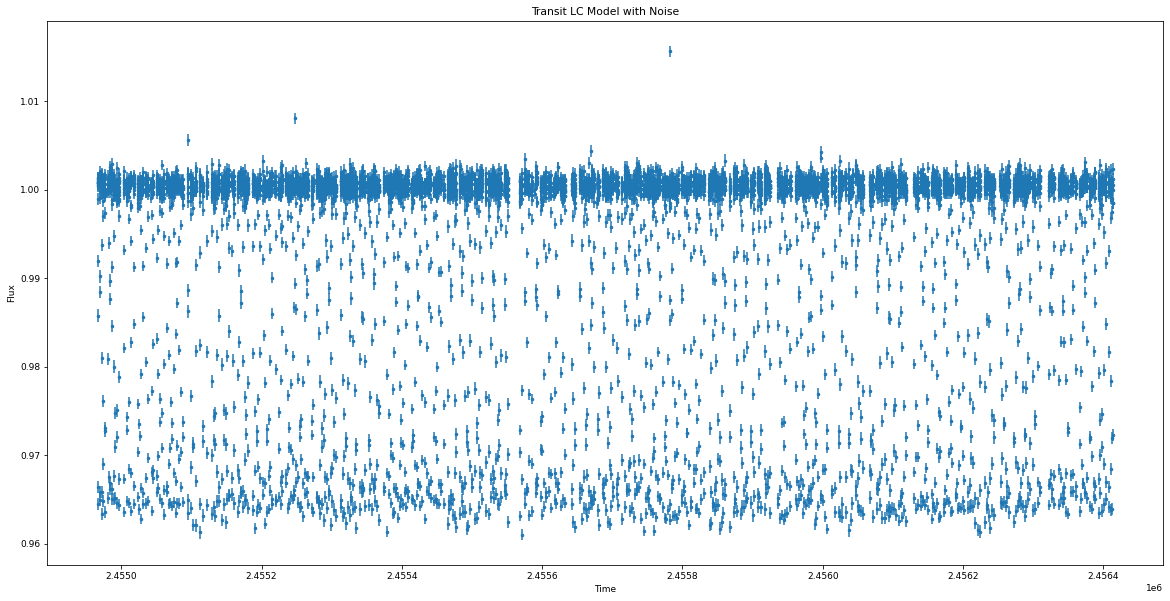

In [31]:
plt.errorbar(koi.time_intransit, koi.flux_intransit, yerr=koi.fluxerr_intransit, fmt='.')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transit LC Model with Noise')

In [32]:
nlive=1000
nsupersample=29
exptimesupersample=0.0201389

In [33]:
dataset, results = koi.do_tfit_juliet(direct, nsupersample=nsupersample, exptimesupersample=exptimesupersample, nlive=nlive)

Fitting KOI 254.01
  analysing data from tutorial02/254.01/jomnest_.txt


In [34]:
res = pd.read_table(direct + 'posteriors.dat')

In [35]:
# Print transit fit results from Juliet
res

,# Parameter Name,,Median,.1,Upper 68 CI,.2,Lower 68 CI
0,P_p1,,2.45524,,0.00000,,0.00000
1,t0_p1,,2455003.82179,,0.00004,,0.00004
2,p_p1,,0.17772,,0.00165,,0.00185
3,b_p1,,0.51896,,0.02392,,0.02816
4,q1_KEPLER,,0.79311,,0.14318,,0.17490
5,q2_KEPLER,,0.20064,,0.08187,,0.06517
6,a_p1,,10.90934,,0.16810,,0.15703
7,mflux_KEPLER,,-0.00052,,0.00001,,0.00001
8,sigma_w_KEPLER,,629.89633,,10.55987,,10.70574


In [36]:
# Save fit planet parameters to variables for convenience
per_f = res.iloc[0][2]
t0_f = res.iloc[1][2]
rprs_f = res.iloc[2][2]
b_f = res.iloc[3][2]
a_f = res.iloc[6][2]

i_f = np.arccos(b_f*(1./a_f))*(180./np.pi)


Below, I print the original parameters and fit parameters, and overlay the fit light curve on the input light curve. 

Because I input $e = 0.0$, the transit fitter should return the exact same parameters I input (because the transit fitter always requires $e = 0.0$).

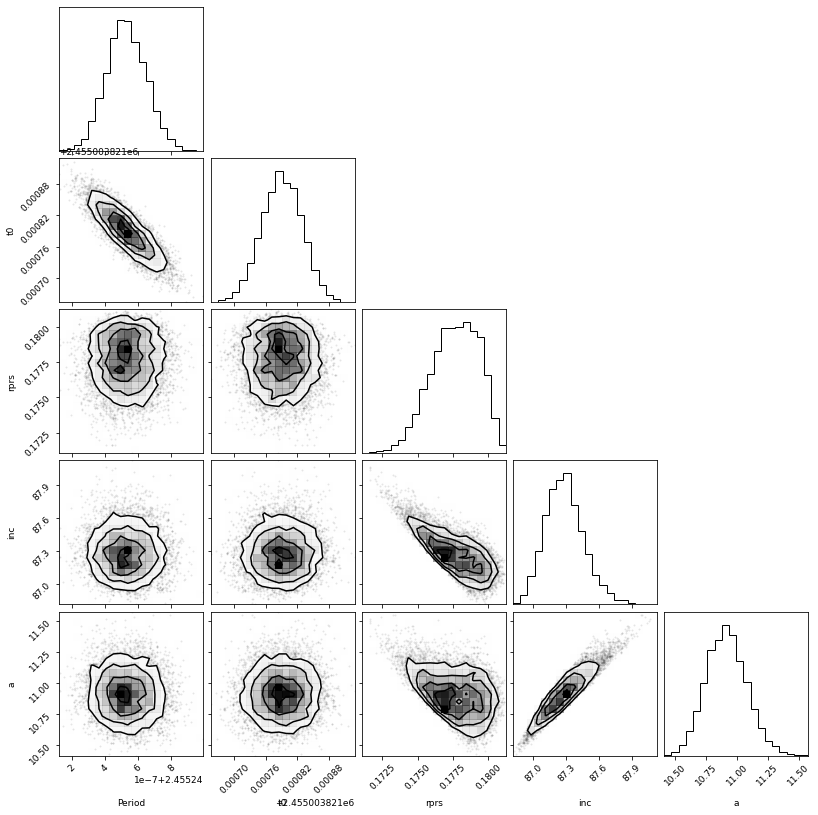

In [37]:
# Plot the transit fit corner plot
p = results.posteriors['posterior_samples']['P_p1']
t0 = results.posteriors['posterior_samples']['t0_p1']
rprs = results.posteriors['posterior_samples']['p_p1']
b = results.posteriors['posterior_samples']['b_p1']
a = results.posteriors['posterior_samples']['a_p1']
inc = np.arccos(b*(1./a))*(180./np.pi)

params = ['Period', 't0', 'rprs', 'inc', 'a']

fs = np.vstack((p, t0, rprs, inc, a))
fs = fs.T

figure = corner.corner(fs, labels=params)

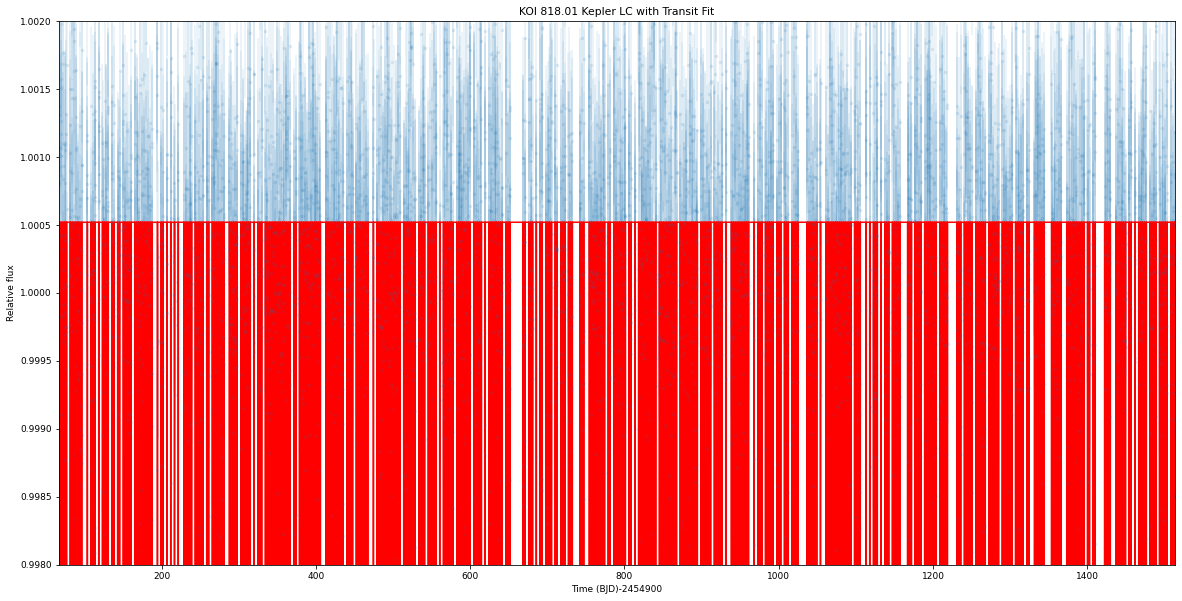

In [38]:
# Plot the data:
plt.errorbar(dataset.times_lc['KEPLER']-2454900, dataset.data_lc['KEPLER'], \
             yerr = dataset.errors_lc['KEPLER'], fmt = '.', alpha = 0.1)

# Plot the model:
plt.plot(dataset.times_lc['KEPLER']-2454900, results.lc.evaluate('KEPLER'), c='r')

# Plot portion of the lightcurve, axes, etc.:
plt.xlabel('Time (BJD)-2454900')
plt.xlim(np.min(dataset.times_lc['KEPLER'])-2454900, np.max(dataset.times_lc['KEPLER'])-2454900)
plt.ylim(0.998, 1.002)
plt.ylabel('Relative flux')
plt.title('KOI 818.01 Kepler LC with Transit Fit')
plt.show()

### Determining T14 and T23

A crucial step to determining the $(e, w)$ distribution from the transit is calculating the total and full transit durations. T14 is the total transit duration (the time between first and fourth contact). T23 is the full transit duration (i.e. the time during which the entire planet disk is in front of the star, the time between second and third contact.)


Here, I'm using equations 14 and 15 from [this textbook](https://sites.astro.caltech.edu/~lah/review/transits_occultations.winn.pdf). We calculate T14 and T23 assuming the orbit must be circular, and using the fit parameters assuming the orbit is circular. (If the orbit is not circular, T14 and T23 will not be correct -- but this is what we want, because they will differ from the true T14 and T23 in a way that reveals the eccentricity of the orbit.)

In [39]:
koi.calc_durations()

In [40]:
print('Total Transit Duration: ', np.mean(koi.T14_dist), koi.T14_errs)
print('Full Transit Duration: ', np.mean(koi.T23_dist), koi.T23_errs)

Total Transit Duration:  0.0759559273513414 (0.0005467926999073586, 0.0004906686209857763)
Full Transit Duration:  0.04581461762343486 (0.001080917812775882, 0.0012094211036618938)


# Get $g$

Print $g$ and $\sigma_{g}$:

In [41]:
koi.get_gs()

In [42]:
g_mean = koi.g_mean
g_sigma = koi.g_sigma

In [43]:
g_mean

0.896551150191697

In [44]:
g_sigma

0.033102035365143

In [45]:
koi.do_eccfit(direct)

20926it [02:43, 128.19it/s, batch: 14 | bound: 0 | nc: 5 | ncall: 190428 | eff(%): 10.989 | loglstar:  1.451 <  3.408 <  3.295 | logz:  1.321 +/-  0.051 | stop:  0.864]         


In [46]:
with open(direct + '/kepewdres.pickle', 'rb') as f:
    ewdres = pickle.load(f)

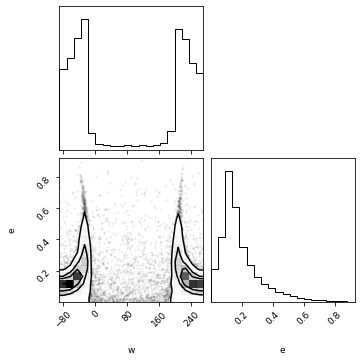

In [47]:
labels = ["w", "e"]

fig = corner.corner(ewdres.samples, labels=labels, title_kwargs={"fontsize": 12}, plot_contours=True)